In [1]:
import langchain
from langchain_google_genai import ChatGoogleGenerativeAI

c:\Users\Vinitha\anaconda3\envs\langchain_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [3]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("langchain_api_key")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [4]:
# Load the LLM model for the generation
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [5]:
# Prepare the embedding model for the vector similarity search
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [6]:
from langchain_core.vectorstores import InMemoryVectorStore
vector_store_1 = InMemoryVectorStore(embeddings)

In [7]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
bs4_strainer = bs4.SoupStrainer(class_=("post"))

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
loader = WebBaseLoader(web_path="https://jalammar.github.io/illustrated-transformer/",
                        bs_kwargs={"parse_only": bs4_strainer}
                        )
docs = loader.load()

In [9]:
assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")
print(docs[0].page_content[:500])

Total characters: 24876

The Illustrated Transformer

Discussions:
Hacker News (65 points, 4 comments), Reddit r/MachineLearning (29 points, 3 comments)


Translations: Arabic, Chinese (Simplified) 1, Chinese (Simplified) 2, French 1, French 2, Italian, Japanese, Korean, Persian, Russian, Spanish 1, Spanish 2, Vietnamese

Watch: MIT’s Deep Learning State of the Art lecture referencing this post

Featured in courses at Stanford, Harvard, MIT, Princeton, CMU and others





Update: This post has now become a book! Check 


In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
split_chunks = text_splitter.split_documents(docs)

print(f"Split blog post into {len(split_chunks)} sub-documents.")

Split blog post into 37 sub-documents.


In [11]:
document_ids = vector_store_1.add_documents(documents=split_chunks)
retriever = vector_store_1.as_retriever()

In [12]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_context_on_attention",
    "Search and return information about Transformers and the attention mechanism used in the Language processing tasks",
)

tools = [retriever_tool]

In [13]:
from typing_extensions import TypedDict,List
from langchain_core.documents import Document
from langgraph.graph.message import add_messages,BaseMessage
from typing import Annotated, Sequence

class State(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [14]:
# Define a grader
from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate

# Data model
class grade(BaseModel):
    """Binary score for relevance check."""

    binary_score: str = Field(description="Relevance score 'yes' or 'no'")


def grader(state:State):
    question = state["messages"][0].content
    context = state["messages"][-1].content
    print("CONTEXT:",context)
    grader_prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )
    llm_with_tool = llm.with_structured_output(grade)
    chain = grader_prompt | llm_with_tool
    scored_result = chain.invoke({"question": question, "context": context})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "end"


In [15]:
rag_prompt = PromptTemplate.from_template("""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context}
Answer:
""")

In [16]:
def generate(state:State):
    print("GENERATING")
    question = state["messages"][0].content
    retrieved_contents = state["messages"][-1].content
    rag_message = rag_prompt.invoke({"question":question,"context":retrieved_contents})
    llm_response = llm.invoke(rag_message).content
    return {"messages":[llm_response]}

In [23]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm2 = ChatGoogleGenerativeAI(model="gemini-1.5-pro")

In [29]:
def agent(state):  
    print("---CALL AGENT---")
    messages = state["messages"]
    model = llm2.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [30]:
# Graph structure to see the control flow
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Define a new graph
workflow = StateGraph(State)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grader,
    {
        "generate":"generate",
        "end":END
    }
)

# Compile
graph = workflow.compile()

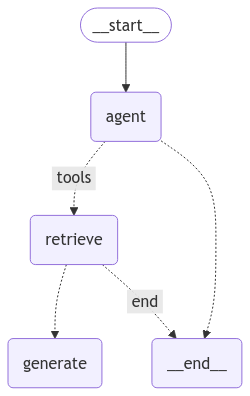

In [31]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
result = graph.invoke({"messages":[("user","What is attention mechanism?")]}) 
print(result["messages"][-1])

---CALL AGENT---
CONTEXT: Self-Attention at a High Level
Don’t be fooled by me throwing around the word “self-attention” like it’s a concept everyone should be familiar with. I had personally never came across the concept until reading the Attention is All You Need paper. Let us distill how it works.
Say the following sentence is an input sentence we want to translate:
”The animal didn't cross the street because it was too tired”
What does “it” in this sentence refer to? Is it referring to the street or to the animal? It’s a simple question to a human, but not as simple to an algorithm.
When the model is processing the word “it”, self-attention allows it to associate “it” with “animal”.
As the model processes each word (each position in the input sequence), self attention allows it to look at other positions in the input sequence for clues that can help lead to a better encoding for this word.

As we are encoding the word "it" in encoder #5 (the top encoder in the stack), part of the a

HumanMessage(content='An attention mechanism allows a model to focus on different parts of an input sequence when processing a specific word.  This helps the model to better understand context and relationships between words.  In the example,  self-attention helps associate "it" with "animal" by considering other parts of the sentence.\n', additional_kwargs={}, response_metadata={}, id='a9cb04d9-2ddb-43b5-b44c-80907d1462e4')

In [28]:
result = graph.invoke({"messages":[("user","What is the fastest animal in the world?")]}) 
print(result["messages"][-1])

---CALL AGENT---
content='' additional_kwargs={'function_call': {'name': 'retrieve_context_on_attention', 'arguments': '{"query": "fastest animal in the world"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-a8cbc5f4-7c0c-4d89-97d6-1239397406bf-0' tool_calls=[{'name': 'retrieve_context_on_attention', 'args': {'query': 'fastest animal in the world'}, 'id': '5040a75d-3054-4562-aaa7-30a4eaf5ab1d', 'type': 'tool_call'}] usage_metadata={'input_tokens': 67, 'output_tokens': 14, 'total_tokens': 81, 'input_token_details': {'cache_read': 0}}
CONTEXT: Acknowledgements
Thanks to Illia Polosukhin, Jakob Uszkoreit, Llion Jones , Lukasz Kaiser, Niki Parmar, and Noam Shazeer for providing feedback on earlier versions of this post.
Please hit me up on Twitter for any corrections or feedback.


    Written on June 27, 2018

As we are encoding the word "it" in encoder #5 (the top encoder in the stack), part of th

{'messages': [HumanMessage(content='What is the fastest animal in the world?', additional_kwargs={}, response_metadata={}, id='f6bc218b-691d-42f2-8cac-a39aa2cf3dcf'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'retrieve_context_on_attention', 'arguments': '{"query": "fastest animal in the world"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-a8cbc5f4-7c0c-4d89-97d6-1239397406bf-0', tool_calls=[{'name': 'retrieve_context_on_attention', 'args': {'query': 'fastest animal in the world'}, 'id': '5040a75d-3054-4562-aaa7-30a4eaf5ab1d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 67, 'output_tokens': 14, 'total_tokens': 81, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='Acknowledgements\nThanks to Illia Polosukhin, Jakob Uszkoreit, Llion Jones , Lukasz Kaiser, Niki Parmar, and Noam Shazeer for providing feedback on earlier versions of this post